In [1]:
##Visualizations for exploration & presentation

In [84]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
import numpy as np
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS 
import copy

In [5]:
#allow in line graphics to view the plots
%matplotlib inline

In [6]:
#resize the graphics - will likely update 
plt.rcParams['figure.figsize'] = (20, 10)

In [8]:
#geojson file from the city of chicago data portal to graph the neighborhood boundaries
#might need to update the path
chicago_neighborhoods = gpd.read_file('Chicago_Data/chicago_boundaries.geojson')

In [11]:
chicago_neighborhoods.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


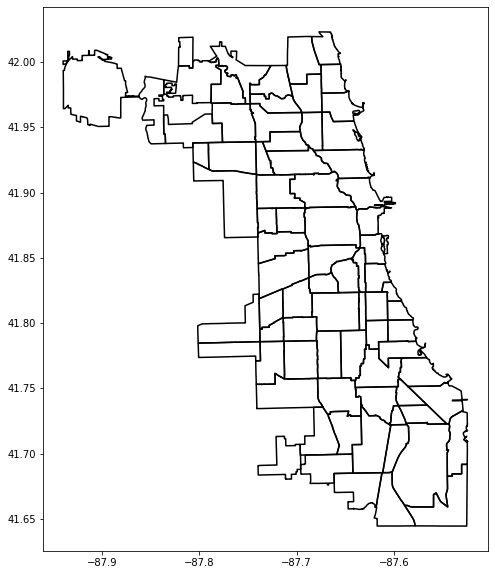

In [10]:
#plot just the neighborhood boundaries? 
chicago_neighborhoods.boundary.plot(color = "black");

In [12]:
#need to create a layer of the restaurants 
#load in the restaurants data frame which should include lat/long - thanks for the update Egemen
restaurant = pd.read_csv("CSVs/all_businesses.csv", index_col =0 )
restaurant.head()

,id,alias,name,is_claimed,is_closed,review_count,rating,coordinates,business_type,price,...,city,state,delivery,pickup,covid_cases,covid_tests,covid_deaths,zipcode_population,latitude,longitude
0,2OGQfIsT33WC7sCKdqKuuw,carmelo-s-taco-place-chicago,Carmelo’s Taco Place,True,False,12.0,4.5,"{'latitude': 41.78663, 'longitude': -87.69294}",Restaurant,NaN,...,Chicago,IL,True,True,14161.0,81300.0,200.0,111850.0,41.786630,-87.692940
1,YULX9j3fdcLtUNYHax19JA,maggie-gyros-and-chicken-chicago,Maggie Gyros & Chicken,False,False,5.0,2.5,"{'latitude': 41.8092351, 'longitude': -87.6178...",Restaurant,NaN,...,Chicago,IL,True,True,1914.0,30921.0,52.0,31972.0,41.809235,-87.617828
2,6hhWuqvuEIEescMsh807pw,morenas-kitchen-chicago,Morena's Kitchen,True,False,41.0,4.5,"{'latitude': 41.916978, 'longitude': -87.753176}",Restaurant,1.0,...,Chicago,IL,True,True,11734.0,72864.0,193.0,90517.0,41.916978,-87.753176
3,VA1mmPgB4HcOpyw_-IA6DQ,northern-trust-chicago,Northern Trust,True,False,8.0,2.5,"{'latitude': 41.881284, 'longitude': -87.632567}",Restaurant,NaN,...,Chicago,IL,False,False,49.0,1114.0,0.0,1174.0,41.881284,-87.632567
4,YHToK3BYKGJudH_UNUCeVw,deli-and-more-chicago,Deli & More,True,False,9.0,4.5,"{'latitude': 41.9333267211914, 'longitude': -8...",Grocery Store,2.0,...,Chicago,IL,True,True,3633.0,72186.0,42.0,70052.0,41.933327,-87.638618


In [14]:
#turn this into a shapely object for the layer 
rest_shapely = gpd.GeoDataFrame(
    restaurant, geometry=gpd.points_from_xy(restaurant.longitude, restaurant.latitude))

In [15]:
#All businesses weirdly includes locations outside of Chicago which were ruining maps, subset to only include Chicago 
rest_chicago = rest_shapely[rest_shapely.city == "Chicago"]

In [16]:
rest_closed = rest_chicago[rest_chicago.is_closed == True]
rest_open = rest_chicago[rest_chicago.is_closed == False]

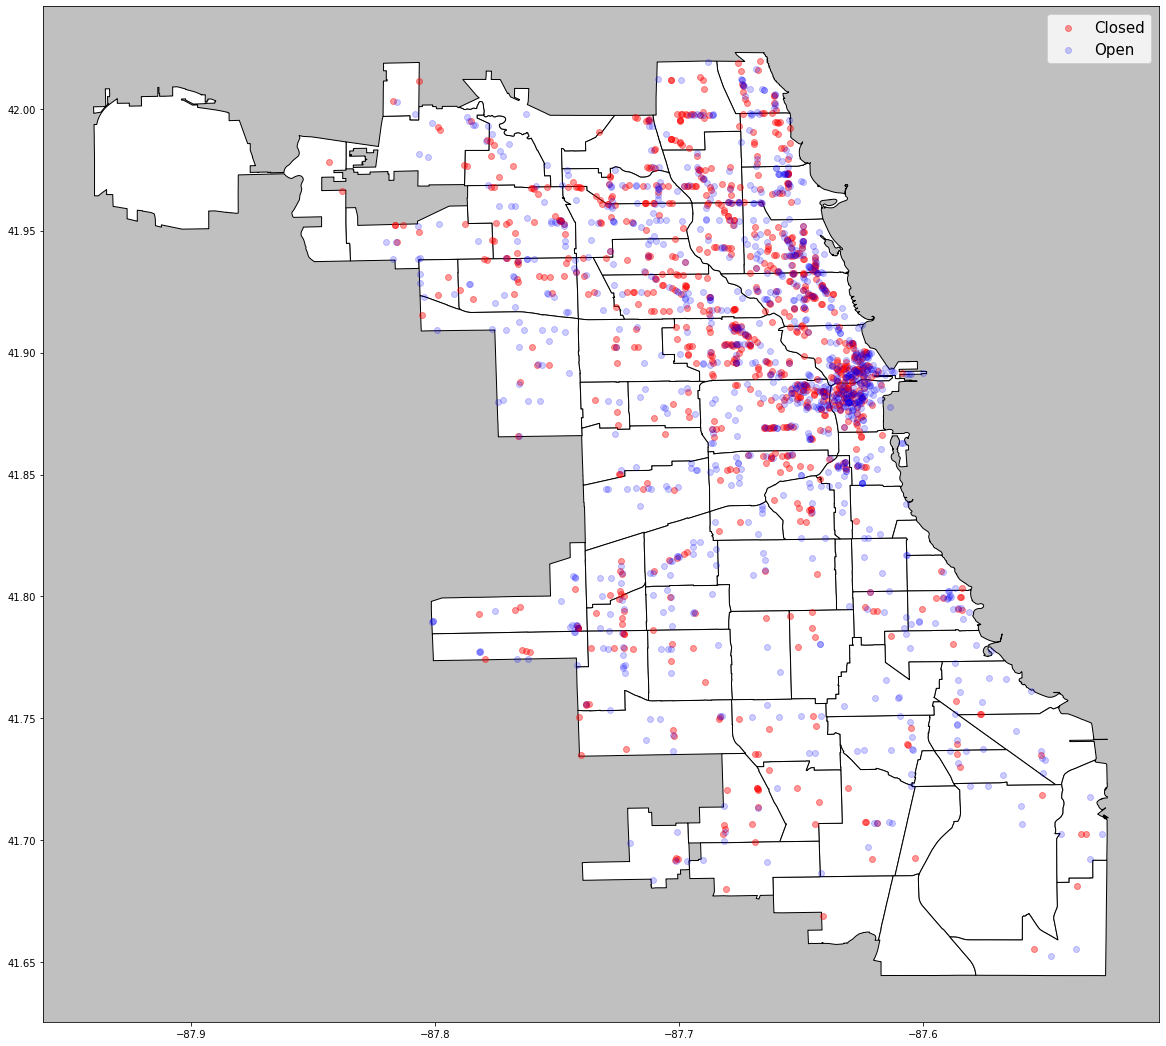

In [21]:
#Layer these  
fig,ax = plt.subplots(figsize = (20,20))
ax.set_facecolor('silver')
chicago_neighborhoods.plot(ax=ax, color = "white", edgecolor = "black")
rest_closed.plot(ax=ax, color = "red", alpha = 0.4, label = "Closed")
rest_open.sample(n=1000).plot(ax=ax, color = "blue", alpha = 0.2, label = "Open")
plt.legend(prop = {"size":15})
#plt.savefig('restaurants.png')

In [22]:
#some work in Jade's Geoplot to plot COVID data as bubble plots - not very successful 
#won't include here 

In [23]:
##Egemen's Code

In [37]:
#identify the number of closed businesses per zipcode
all_businesses = pd.read_csv('CSVs/all_businesses.csv', index_col=0, dtype={'zip_code': str})
closed = all_businesses[all_businesses.is_closed]
zipcodes_closed = closed.loc[:, ['id', 'zip_code']].groupby('zip_code').count().sort_values('id', ascending=False)
zipcodes_closed

,id
zip_code,
60622,57
60614,50
60607,47
60647,43
60618,40
60657,39
60625,32
60654,31
60611,31


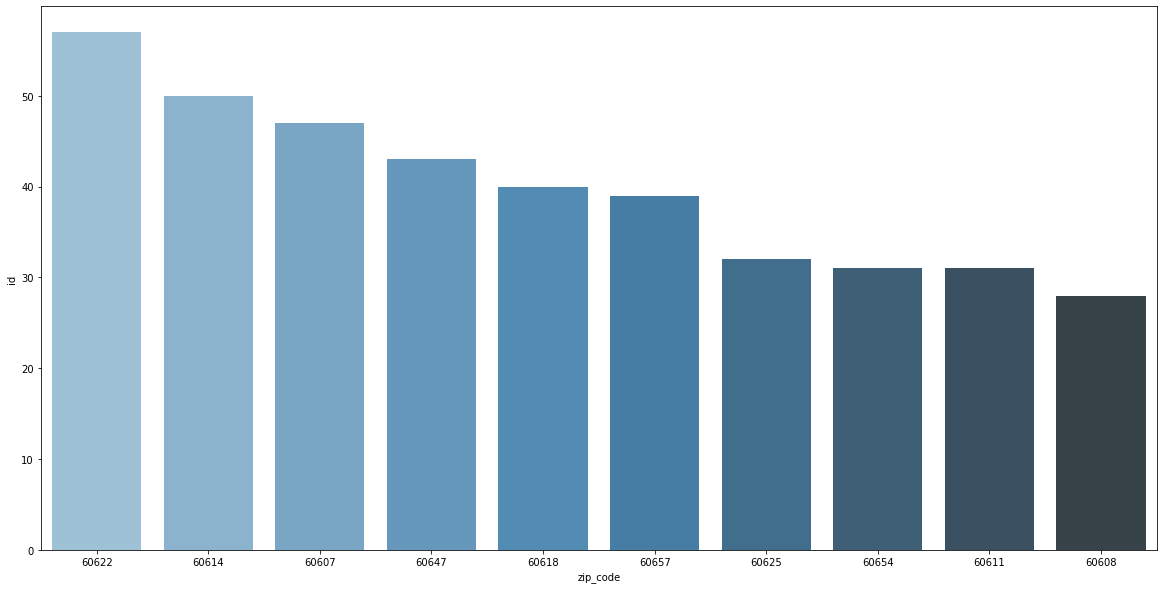

In [38]:
#plot of the top 10 zipcodes with the most closed businesses (most affected)
closed_by_zip_top10 = sns.barplot(x=zipcodes_closed.index[:10], y=zipcodes_closed.id[:10], palette="Blues_d", order=zipcodes_closed.index[:10])
fig = closed_by_zip_top10.get_figure()
#fig.savefig('top10closedzips.png')

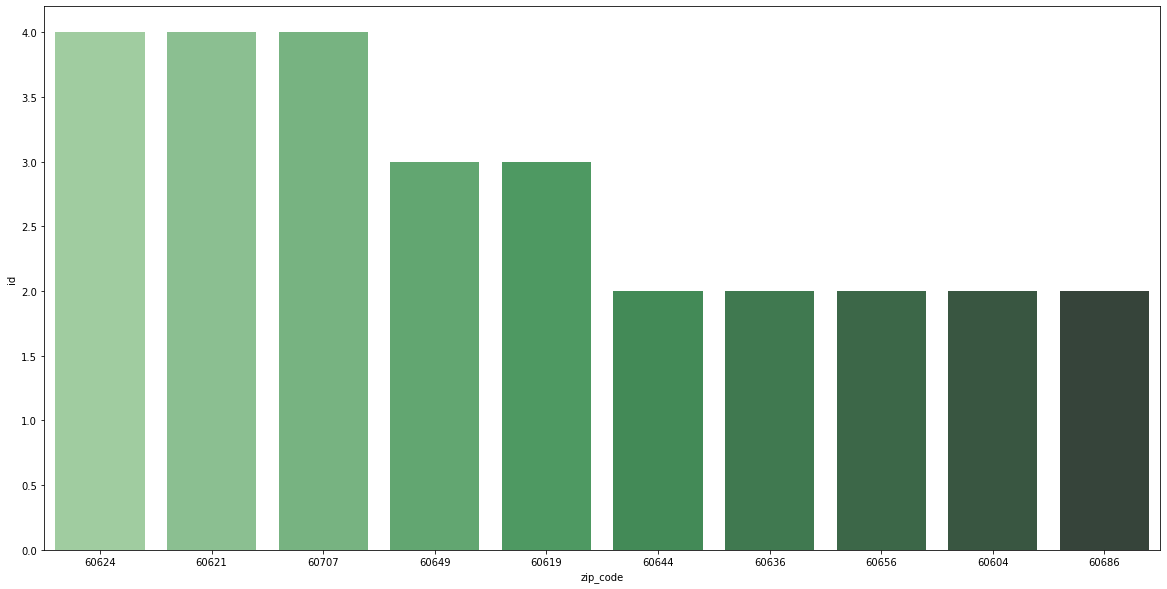

In [39]:
#plot of the bottom 10 zipcodes with the most closed businesses (least affected)
closed_by_zip_bottom10 = sns.barplot(x=zipcodes_closed.index[-12:-2], y=zipcodes_closed.id[-12:-2], palette="Greens_d", order=zipcodes_closed.index[-12:-2])
fig = closed_by_zip_top10.get_figure()
#fig.savefig('bottom10closedzips.png')

In [40]:
_open = all_businesses[all_businesses.is_closed==False]
zipcodes_open = _open.loc[:, ['id', 'zip_code']].groupby('zip_code').count().sort_values('id', ascending=False)

In [41]:
#ratio of closed to open 
zip_ratio_closed = zipcodes_open.merge(zipcodes_closed, left_index=True, right_index=True, how='right')
zip_ratio_closed['ratio_closed'] = zip_ratio_closed.id_y/zip_ratio_closed.id_x
zip_ratio_closed = zip_ratio_closed.iloc[:, [-1]]
zip_ratio_closed.sort_values('ratio_closed', ascending=False, inplace=True)

In [42]:
#Geojson with Chicago zipcodes 
chicago_zipcodes = gpd.read_file('Chicago_Data/zipcodes1.geojson')


In [44]:
chicago_zip_closed = chicago_zipcodes.merge(zip_ratio_closed, right_index=True, left_on='ZIP')

In [45]:
#some zipcodes plotted to the same shape
zipcodes_closed.loc[['60601', '60602', '60603', '60604', '60605', '60611'], :].id.sum()

81

In [46]:
zipcodes_closed.loc[['60606', '60607', '60661'], :].id.sum()

81

In [48]:
zipcodes_closed.at['12311', ['id']] = zipcodes_closed.loc[['60601', '60602', '60603', '60604', '60605', '60611'], :].id.sum()

zipcodes_closed.at['6761', ['id']] = zipcodes_closed.loc[['60606', '60607', '60661'], :].id.sum()

zipcodes_closed.at['60610', ['id']] = zipcodes_closed.loc[['60610', '60654'], :].id.sum()

zipcodes_closed.at['60622', ['id']] = zipcodes_closed.loc[['60622', '60622'], :].id.sum()

zipcodes_open.at['12311', ['id']] = zipcodes_open.loc[['60601', '60602', '60603', '60604', '60605', '60611'], :].id.sum()

zipcodes_open.at['6761', ['id']] = zipcodes_open.loc[['60606', '60607', '60661'], :].id.sum()

zipcodes_open.at['60610', ['id']] = zipcodes_open.loc[['60610', '60654'], :].id.sum()

zipcodes_open.at['60622', ['id']] = zipcodes_open.loc[['60622', '60622'], :].id.sum()

zip_ratio_closed1 = zipcodes_open.merge(zipcodes_closed, left_index=True, right_index=True, how='right')
zip_ratio_closed1['ratio_closed'] = zip_ratio_closed1.id_y/zip_ratio_closed1.id_x
zip_ratio_closed1 = zip_ratio_closed1.iloc[:, [-1]]
zip_ratio_closed1.sort_values('ratio_closed', ascending=False, inplace=True)

chicago_zip_closed1 = chicago_zipcodes.merge(zip_ratio_closed1, right_index=True, left_on='ZIP')

In [49]:
#use this to label neighborhoods
chicago_neighborhoods["center"] = chicago_neighborhoods["geometry"].centroid
za_points = chicago_neighborhoods.copy()
za_points.set_geometry("center", inplace = True)

<ipython-input-49-515042c5108a>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  chicago_neighborhoods["center"] = chicago_neighborhoods["geometry"].centroid


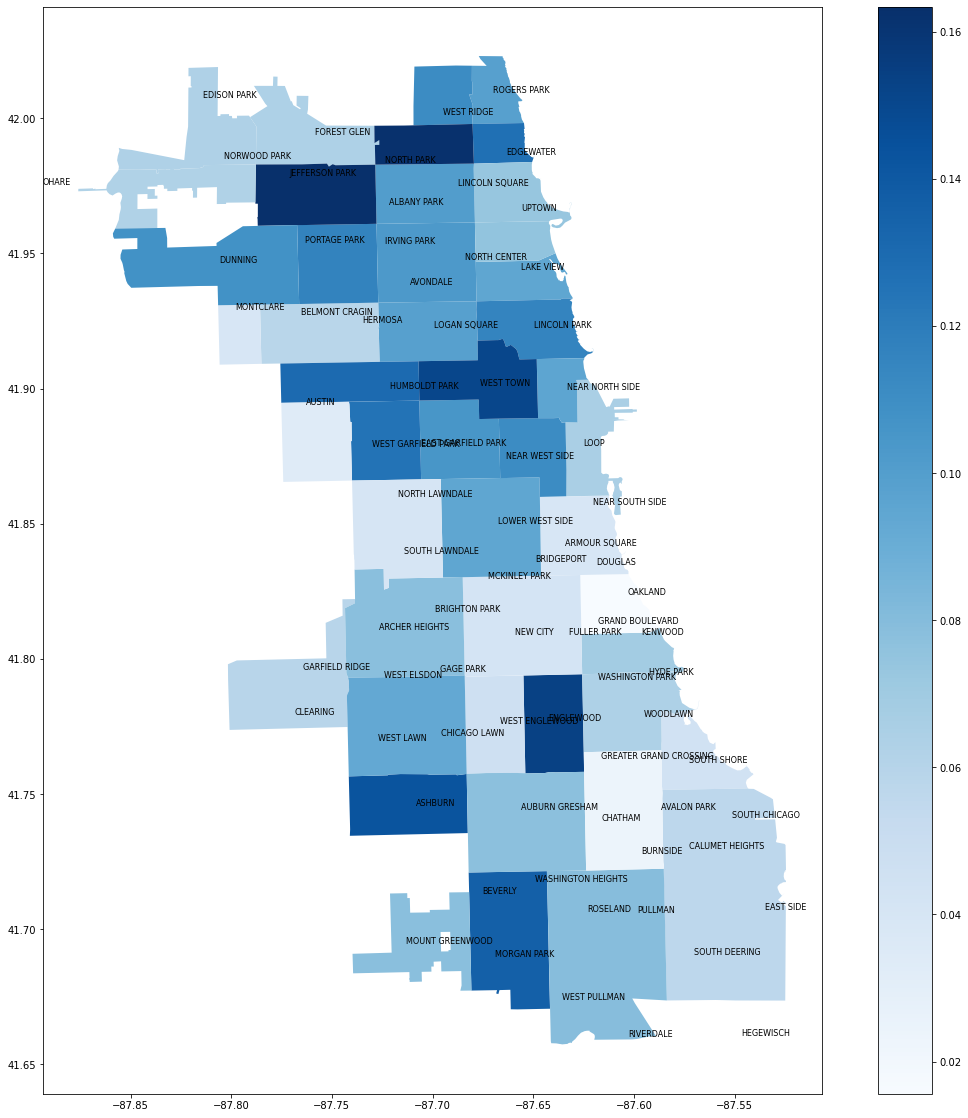

In [50]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_facecolor('white')
chicago_zip_closed1.plot(ax=ax, column=chicago_zip_closed1.ratio_closed, legend=True, cmap='Blues')
texts = []

for x, y, label in zip(za_points.geometry.x, za_points.geometry.y, za_points["community"]):
    texts.append(plt.text(x, y, label, fontsize = 8))
plt.savefig('ratio1.png')

In [51]:
#look at COVID data
all_businesses['death_rate'] = all_businesses.covid_deaths / all_businesses.zipcode_population
all_businesses['case_rate'] = all_businesses.covid_cases / all_businesses.zipcode_population

rates = all_businesses.loc[:, ['zip_code', 'death_rate', 'case_rate']].drop_duplicates('zip_code')

chicago_rates_zip = chicago_zip_closed1.merge(rates, left_on='ZIP', right_on='zip_code', how='left')

In [52]:
#pick representative COVID rates for the overlapping zipcodes
chicago_rates_zip.at[43, 'ZIP'] = 60601
chicago_rates_zip.at[43, 'death_rate'] = rates[rates.zip_code=='60601'].iat[0, 1]
chicago_rates_zip.at[43, 'case_rate'] = rates[rates.zip_code=='60601'].iat[0, 2]

chicago_rates_zip.at[44, 'ZIP'] = 60606
chicago_rates_zip.at[44, 'death_rate'] = rates[rates.zip_code=='60606'].iat[0, 1]
chicago_rates_zip.at[44, 'case_rate'] = rates[rates.zip_code=='60606'].iat[0, 2]

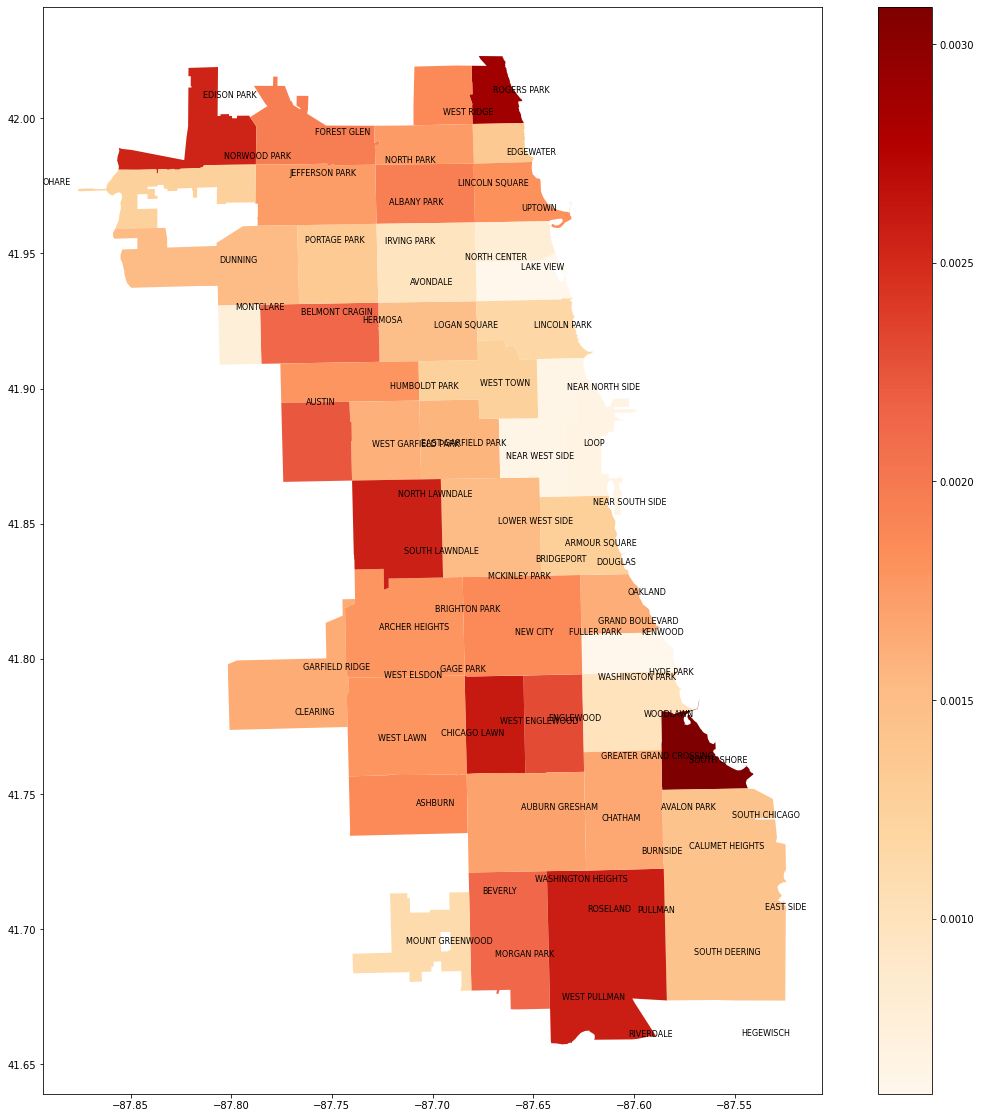

In [53]:
#Deaths 
fig, ax = plt.subplots(figsize=(20,20))
ax.set_facecolor('white')
chicago_rates_zip.plot(ax=ax, column=chicago_rates_zip.death_rate, legend=True, cmap='OrRd')
texts = []

for x, y, label in zip(za_points.geometry.x, za_points.geometry.y, za_points["community"]):
    texts.append(plt.text(x, y, label, fontsize = 8))
plt.savefig('death_rates.png')

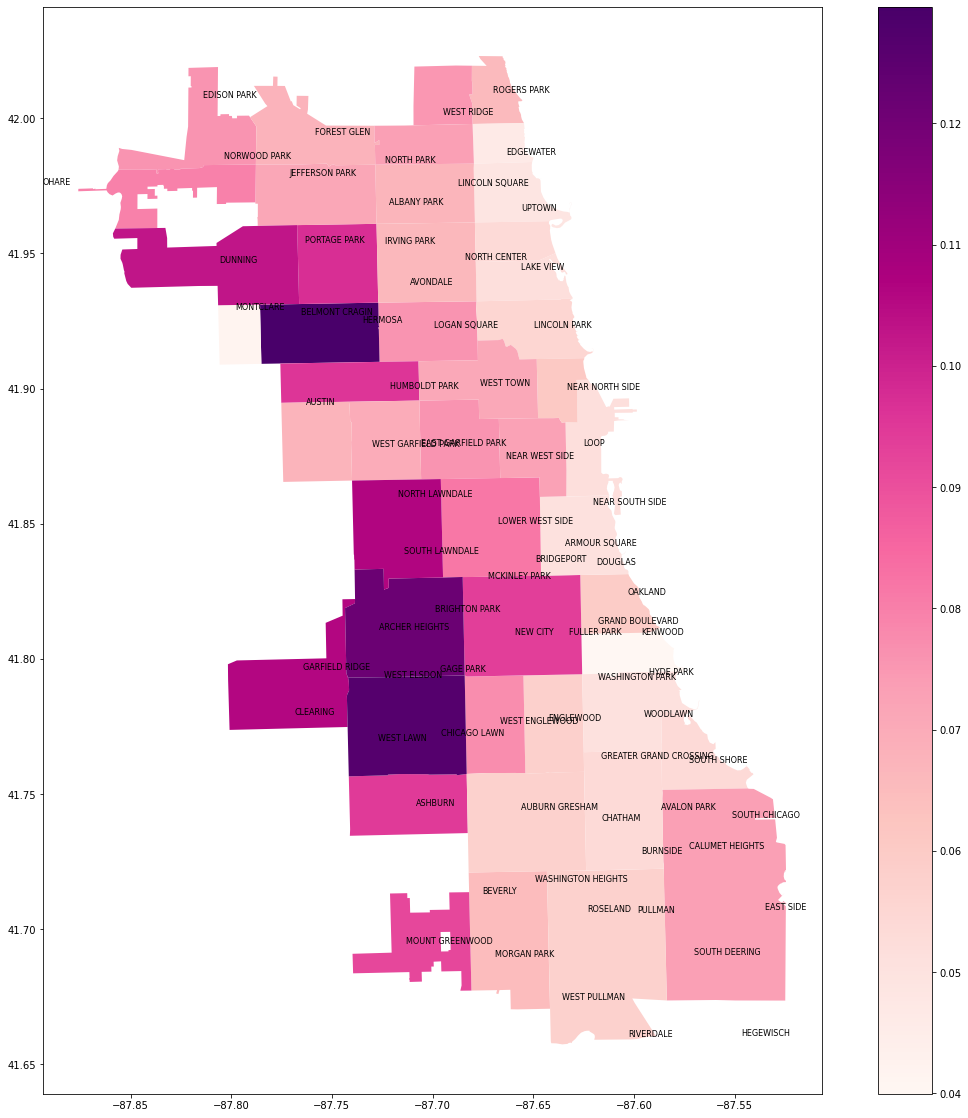

In [54]:
#Cases
fig, ax = plt.subplots(figsize=(20,20))
ax.set_facecolor('white')
chicago_rates_zip.plot(ax=ax, column=chicago_rates_zip.case_rate, legend=True, cmap='RdPu')
texts = []

for x, y, label in zip(za_points.geometry.x, za_points.geometry.y, za_points["community"]):
    texts.append(plt.text(x, y, label, fontsize = 8))
plt.savefig('case_rates.png')

In [56]:
##Sabina's visualizations
#for more detail, refer to Sabina_SummaryStats

In [57]:
def create_word_cloud(dataframe, column, sep_val, stop_words, outputfilename):
    '''
    Function to create a wordcloud based on the text in a specified column of a specified
    dataframe. In the business dataset, the words in 'alias' are seperated by '-' but
    in name by ' ' so we specify that as a parameter as well. Additionally, if there are 
    stop words beyond those included in the wordcloud package, they can be added (adding 'chicago' 
    proves to clean many of our word cloud outputs)
    '''
    
    full_terms = ""
    for response in dataframe[column]:
        sep_resp = response.replace(sep_val, ' ').split(' ')
        for word in sep_resp: #append word
            full_terms += word.lower() + " " #" ".join(word.lower())+" "#.append(word.lower())

    mystopwords = copy.deepcopy(set(STOPWORDS))
    for stop_w in stop_words:
        mystopwords.add(stop_w)

    mywordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = mystopwords, 
                    min_font_size = 10).generate(full_terms) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(mywordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()
    
    mywordcloud.to_file(outputfilename)
    
    return full_terms
        
#alias_list = [alias_list.append(alias) for alias in all_businesses['alias']]

In [59]:
means = {'type': ['review_count', 'rating'], 'closed': [round(closed[['review_count']].mean()[0],2), round(closed[['rating']].mean()[0], 2)], 'open': [round(_open[['review_count']].mean()[0], 2), round(_open[['rating']].mean()[0],2)], 'all_businesses': [round(all_businesses[['review_count']].mean()[0], 2), round(all_businesses[['rating']].mean()[0], 2)]}
pd.DataFrame(means)

,type,closed,open,all_businesses
0,review_count,124.40,127.26,127.06
1,rating,3.63,3.57,3.57


In [64]:
busi_type = copy.deepcopy(all_businesses.groupby("business_type"))
#to avoid changing the original dataset
desc_df = pd.DataFrame(busi_type.describe())
#.sort_values('count', ascending=False)
desc_df['review_count'].sort_values('count', ascending=False)[0:20]

,count,mean,std,min,25%,50%,75%,max
business_type,,,,,,,,
Restaurant,2535.0,199.836686,410.699347,1.0,19.00,76.0,227.50,8713.0
Grocery Store,248.0,16.483871,34.589433,1.0,2.00,5.0,17.00,395.0
School,113.0,4.221239,8.525942,1.0,1.00,2.0,4.00,87.0
Children's Services Facility,60.0,7.266667,6.645673,1.0,1.75,5.0,11.25,25.0
Bakery,53.0,64.150943,172.801397,1.0,6.00,15.0,45.00,1152.0
Long Term Care,48.0,4.479167,4.828945,1.0,1.00,2.5,5.25,25.0
Daycare Above and Under 2 Years,23.0,9.782609,11.114922,1.0,2.00,5.0,13.50,42.0
Catering,22.0,156.818182,487.745800,1.0,6.25,22.0,54.25,2304.0
Liquor,19.0,42.947368,66.841000,1.0,2.50,14.0,42.50,213.0


In [62]:
## Word density plot of the alias (descriptors) for ALL businesses in chicago

In [ ]:
cleaned_alias = create_word_cloud(all_businesses, 'alias', '-', ['chicago'], "all_alias_wordcloud.png")

uncleaned_res_name = create_word_cloud(all_businesses, 'name', ' ', [], "all_name_wordcloud.png")

In [65]:
## Word clouds of the alias (descriptors) and restaurant names for open and closed businesses in chicago - as a comparison

In [ ]:
closed_alias_wc = create_word_cloud(closed_df, 'alias', '-', ['chicago'], "closed_alias_wordcloud.png")

open_alias_wc = create_word_cloud(open_df, 'alias', '-', ['chicago'], "open_alias_wordcloud.png")

closed_name_wc = create_word_cloud(closed_df, 'name', '-', [], "closed_name_wordcloud.png")

open_name_wc = create_word_cloud(open_df, 'name', '-', [], "open_name_wordcloud.png")

In [75]:
rating_zipc_df = _open.groupby(['zip_code'],as_index = True)['rating'].mean()
reviews_zipc_df = _open.groupby(['zip_code'],as_index = True)['review_count'].mean()
merge_rating_reviews = pd.merge(rating_zipc_df, reviews_zipc_df, on='zip_code')
merge_rating_reviews.reset_index(inplace=True)

In [77]:
closed_rating_zipc_df = closed.groupby(['zip_code'],as_index = True)['rating'].mean()
closed_reviews_zipc_df = closed.groupby(['zip_code'],as_index = True)['review_count'].mean()
closed_merge_rating_reviews = pd.merge(closed_rating_zipc_df, closed_reviews_zipc_df, on='zip_code')
closed_rate_mean = closed_merge_rating_reviews['rating'].mean()
closed_merge_rating_reviews["rating_eval"] = ["above average" if rate > closed_rate_mean else "below average" for rate in closed_merge_rating_reviews['rating']]
closed_merge_rating_reviews.reset_index(inplace=True)

merge_rating_reviews['is_closed'] = False
closed_merge_rating_reviews['is_closed'] = True
all_merge_rating_reviews = pd.concat([merge_rating_reviews, closed_merge_rating_reviews])

all_merge_rating_reviews


,zip_code,rating,review_count,is_closed,rating_eval
0,60007,3.250000,35.500000,False,NaN
1,60018,3.500000,66.000000,False,NaN
2,60068,3.833333,146.666667,False,NaN
3,60076,3.615385,75.384615,False,NaN
4,60077,3.119048,127.476190,False,NaN
...,...,...,...,...,...
53,60659,3.777778,61.111111,True,above average
54,60660,3.444444,83.222222,True,below average
55,60661,4.029412,181.588235,True,above average
56,60686,3.250000,32.500000,True,below average


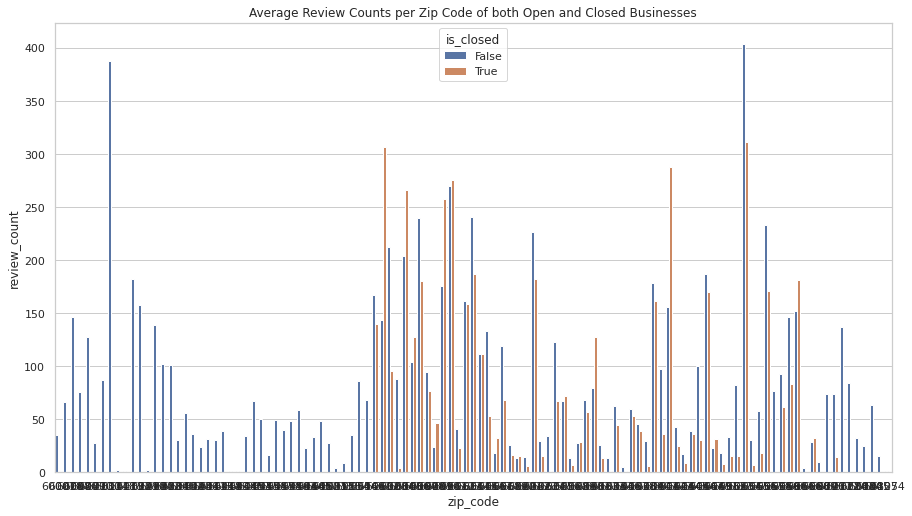

In [78]:
#ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)
sns.set_context("paper", font_scale=1.2)
sns.set_theme(style="whitegrid")
avg_rating_eval = sns.barplot(x = "zip_code", y = "review_count", hue = "is_closed", data = all_merge_rating_reviews).set_title("Average Review Counts per Zip Code of both Open and Closed Businesses")
fig = avg_rating_eval.get_figure()
fig.set_size_inches(15, 8.27)
fig.savefig('ALL_avg_reviews.png')


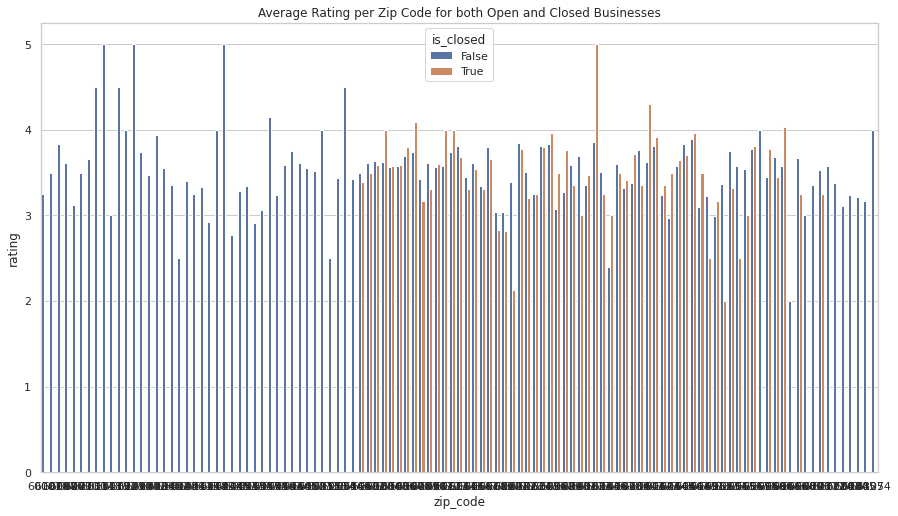

In [79]:
sns.set_context("paper", font_scale=1.2)
sns.set_theme(style="whitegrid")
avg_rating_eval = sns.barplot(x = "zip_code", y = "rating", hue = "is_closed", data = all_merge_rating_reviews).set_title("Average Rating per Zip Code for both Open and Closed Businesses")
fig = avg_rating_eval.get_figure()
fig.set_size_inches(15, 8.27)
fig.savefig('ALL_avg_rating.png')

In [85]:
merge_rating_reviews = pd.merge(rating_zipc_df, reviews_zipc_df, on='zip_code')
pd.DataFrame(merge_rating_reviews)

,rating,review_count
zip_code,,
60007,3.250000,35.500000
60018,3.500000,66.000000
60068,3.833333,146.666667
60076,3.615385,75.384615
60077,3.119048,127.476190
...,...,...
60803,3.109375,31.953125
60804,3.243333,24.913333
60805,3.213115,63.868852


In [86]:
rating_zipc_df.sort_values(ascending=False).head() #max = 5
reviews_zipc_df.sort_values(ascending=False).head() #max = 403
closed_rating_zipc_df.sort_values(ascending=False).head() #max = 5
closed_reviews_zipc_df.sort_values(ascending=False).head() #max = 310

zip_code
60654    310.935484
60602    306.555556
60642    288.052632
60611    275.483871
60605    265.923077
Name: review_count, dtype: float64

In [88]:
#ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)
sns.set_context("paper", font_scale=1.2)
sns.set_theme(style="whitegrid")
avg_rating_eval = sns.barplot(x = "zip_code", y = "review_count", hue = "rating_eval", data = merge_rating_reviews).set_title("Scaled Mean Review Counts per Zip Code for Open Businesses")
fig = avg_rating_eval.get_figure()
fig.set_size_inches(15, 8.27)
fig.savefig('OPENavg_rating_eval.png')


ValueError: Could not interpret input 'zip_code'

ValueError: Could not interpret input 'zip_code'

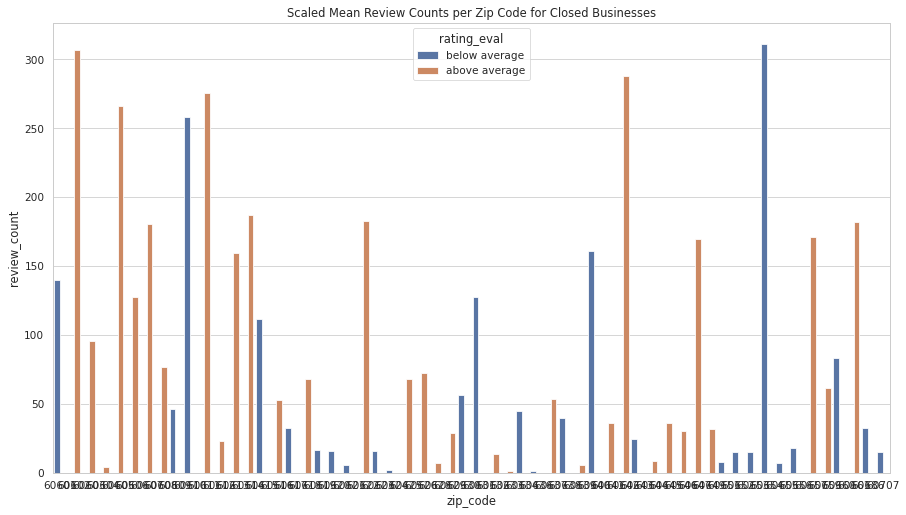

In [82]:
#ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)
sns.set_context("paper", font_scale=1.2)
sns.color_palette("hls", 8)
closed_avg_rating_eval = sns.barplot(x = "zip_code", y = "review_count", hue = "rating_eval", data = closed_merge_rating_reviews).set_title("Scaled Mean Review Counts per Zip Code for Closed Businesses")
fig = closed_avg_rating_eval.get_figure()
fig.set_size_inches(15, 8.27)
fig.savefig('CLOSEDavg_rating_eval.png')



sns.set_context("paper", font_scale=1.2)
avg_rating_eval = sns.barplot(x = "zip_code", y = "review_count", hue = "rating_eval", data = merge_rating_reviews).set_title("Scaled Mean Review Counts per Zip Code")
fig = avg_rating_eval.get_figure()
fig.set_size_inches(15, 8.27)
fig.savefig('avg_rating_eval.png')
